In [ ]:
!pip install install patool
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 10.4 MB/s eta 0:00:00


In [ ]:
import patoolib

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
patoolib.extract_archive('/content/gdrive/MyDrive/Brain_Tumor_Dataset_PR.zip', outdir="/content/Brain_tumor_dataset")
patoolib.extract_archive('/content/gdrive/MyDrive/Brain_tumor_dataset.zip', outdir="/content/Brain_Tumor_Dataset")

INFO patool: Extracting /content/gdrive/MyDrive/Brain_Tumor_Dataset_PR.zip ...
INFO:patool:Extracting /content/gdrive/MyDrive/Brain_Tumor_Dataset_PR.zip ...
INFO patool: ... creating output directory `/content/Brain_tumor_dataset'.
INFO:patool:... creating output directory `/content/Brain_tumor_dataset'.
INFO patool: running /usr/bin/7z x -o/content/Brain_tumor_dataset -- /content/gdrive/MyDrive/Brain_Tumor_Dataset_PR.zip
INFO:patool:running /usr/bin/7z x -o/content/Brain_tumor_dataset -- /content/gdrive/MyDrive/Brain_Tumor_Dataset_PR.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/gdrive/MyDrive/Brain_Tumor_Dataset_PR.zip extracted to `/content/Brain_tumor_dataset'.
INFO:patool:... /content/gdrive/MyDrive/Brain_Tumor_Dataset_PR.zip extracted to `/content/Brain_tumor_dataset'.
INFO patool: Extracting /content/gdrive/MyDrive/Brain_tumor_dataset.zip ...
INFO:patool:Extracting /content/gdrive/MyDrive/Brain_tumor_dataset.zip ...
INFO patool: ... c

'/content/Brain_Tumor_Dataset'

In [ ]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import pywt
import pywt.data
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [ ]:
# Function for importing data
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)

    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)

    return data_path, data_labels


In [ ]:
# Setting up file paths for training and testing
USER_PATH = r"/content/Brain_Tumor_Dataset"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


Training Counts
{'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}

Testing Counts
{'pituitary': 300, 'notumor': 405, 'meningioma': 306, 'glioma': 300}


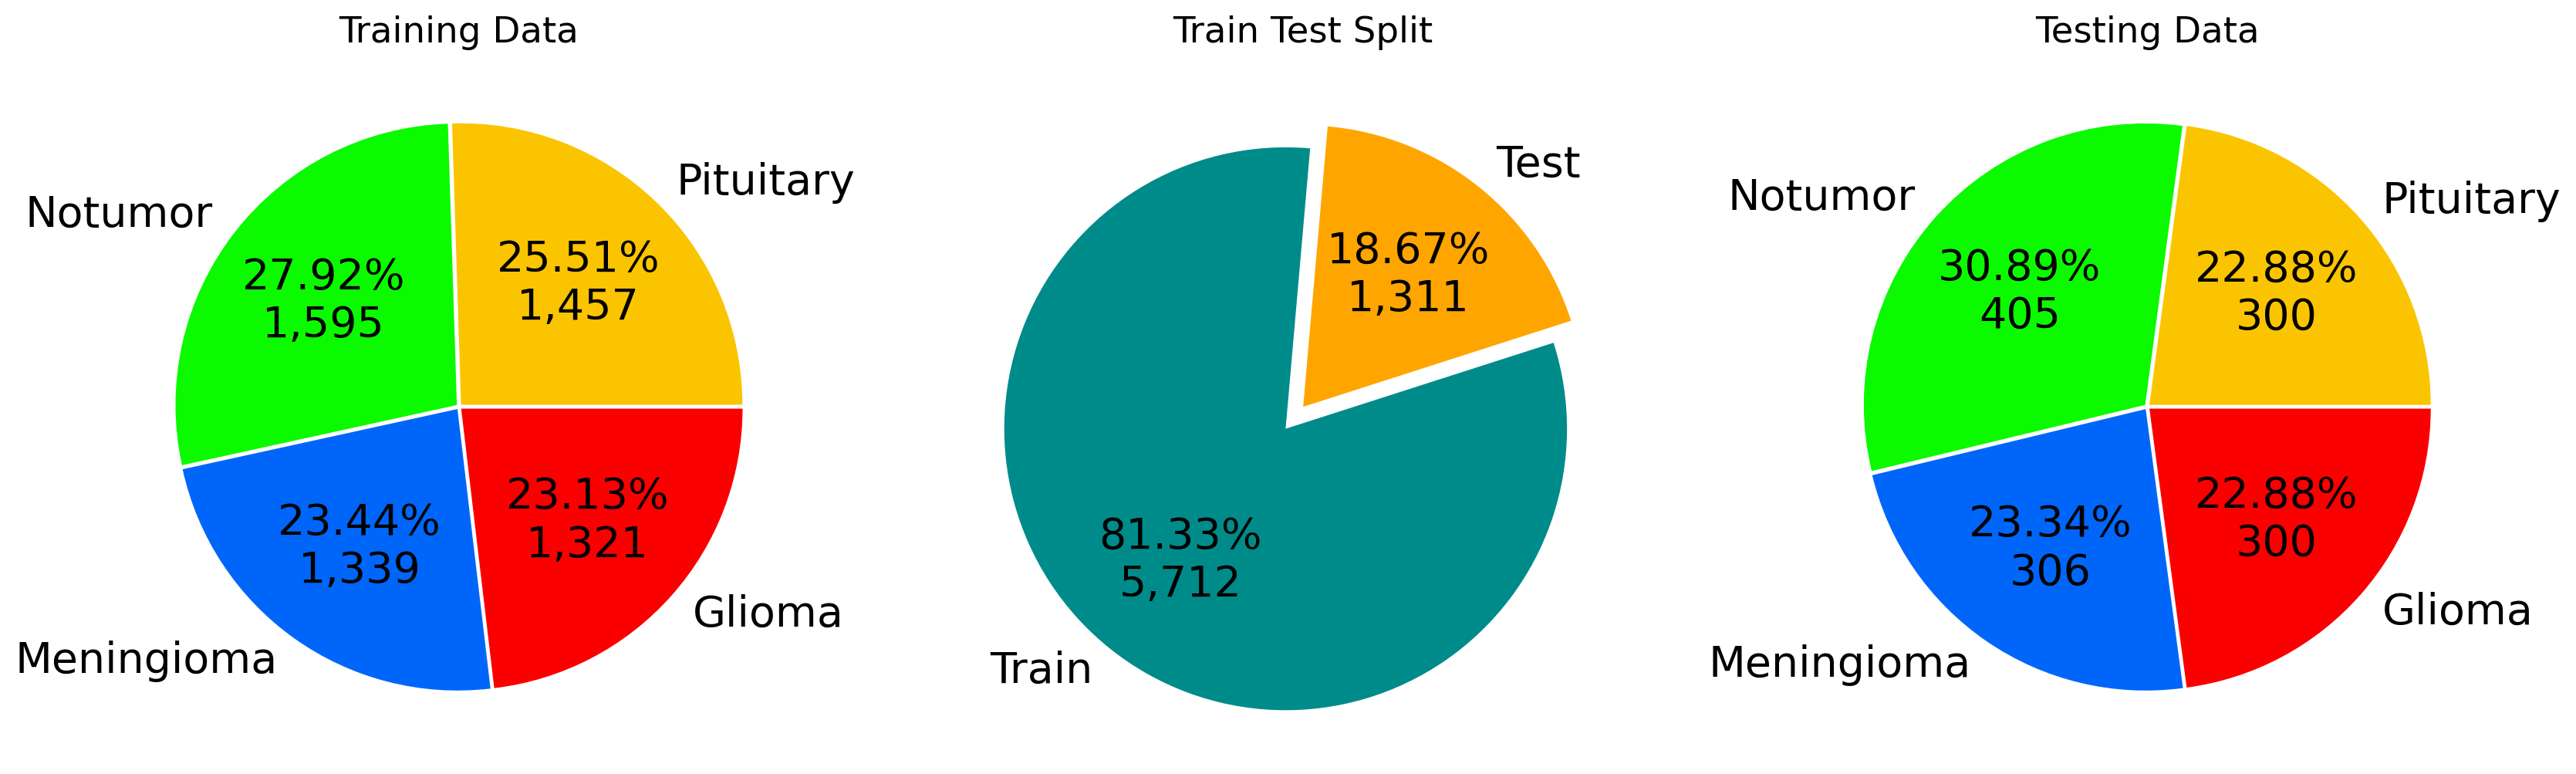

In [ ]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(test_labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)


plt.show()

In [ ]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4

    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break

        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()

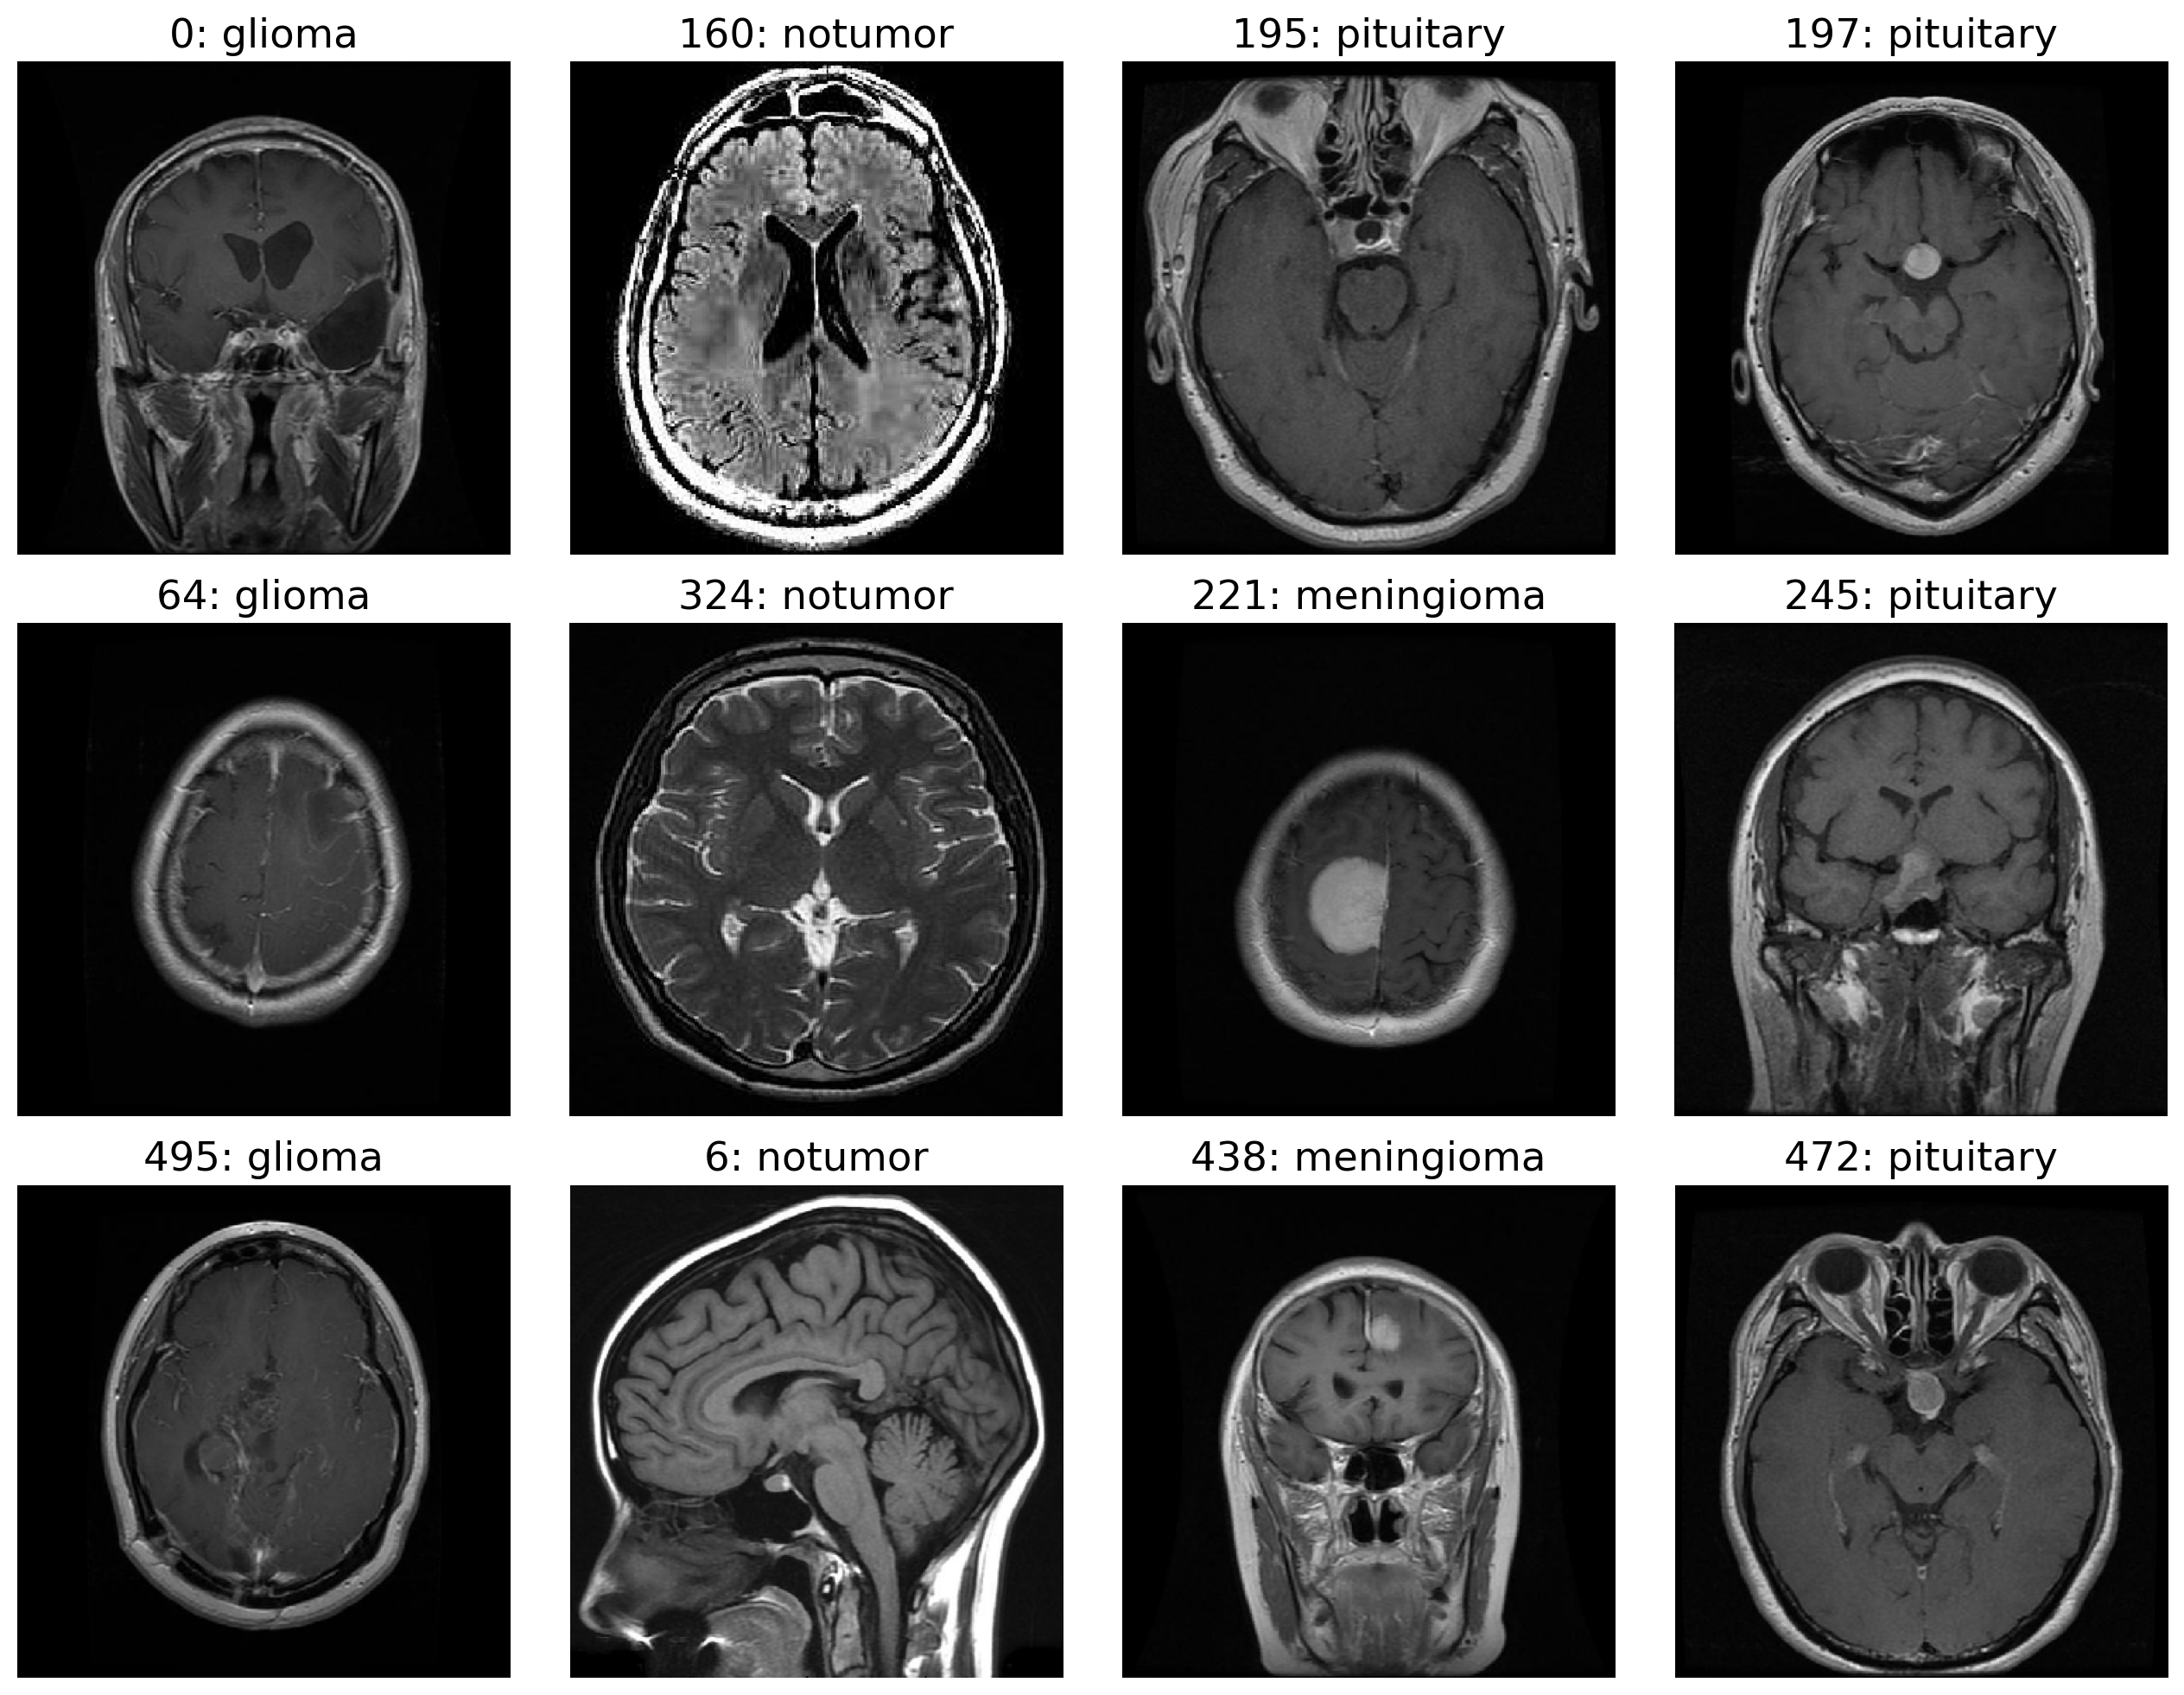

In [ ]:
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths,
            train_labels,
            index_list=[0, 160, 195, 197,
                        64, 324, 221, 245,
                        495, 6, 438, 472],
            im_size=350,
            figsize=(13,10),
            save=SAVE)

In [ ]:
# Image size
image_size = (224, 224)

# Training batch size
batch_size = 32

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

# Now we are trained the augmented data
# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
def show_images_ImageDataGenerator(ImageDataGenerator, num_samples=20, num_rows=5, num_cols=4, figsize=(16, 20), save=False):
    """
    Function to visualize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    augmented_samples = train_generator.next()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i in range(num_rows):
        for j in range(num_cols):
            ax = axes[i, j]
            ax.imshow(images[i * num_cols + j])
            ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

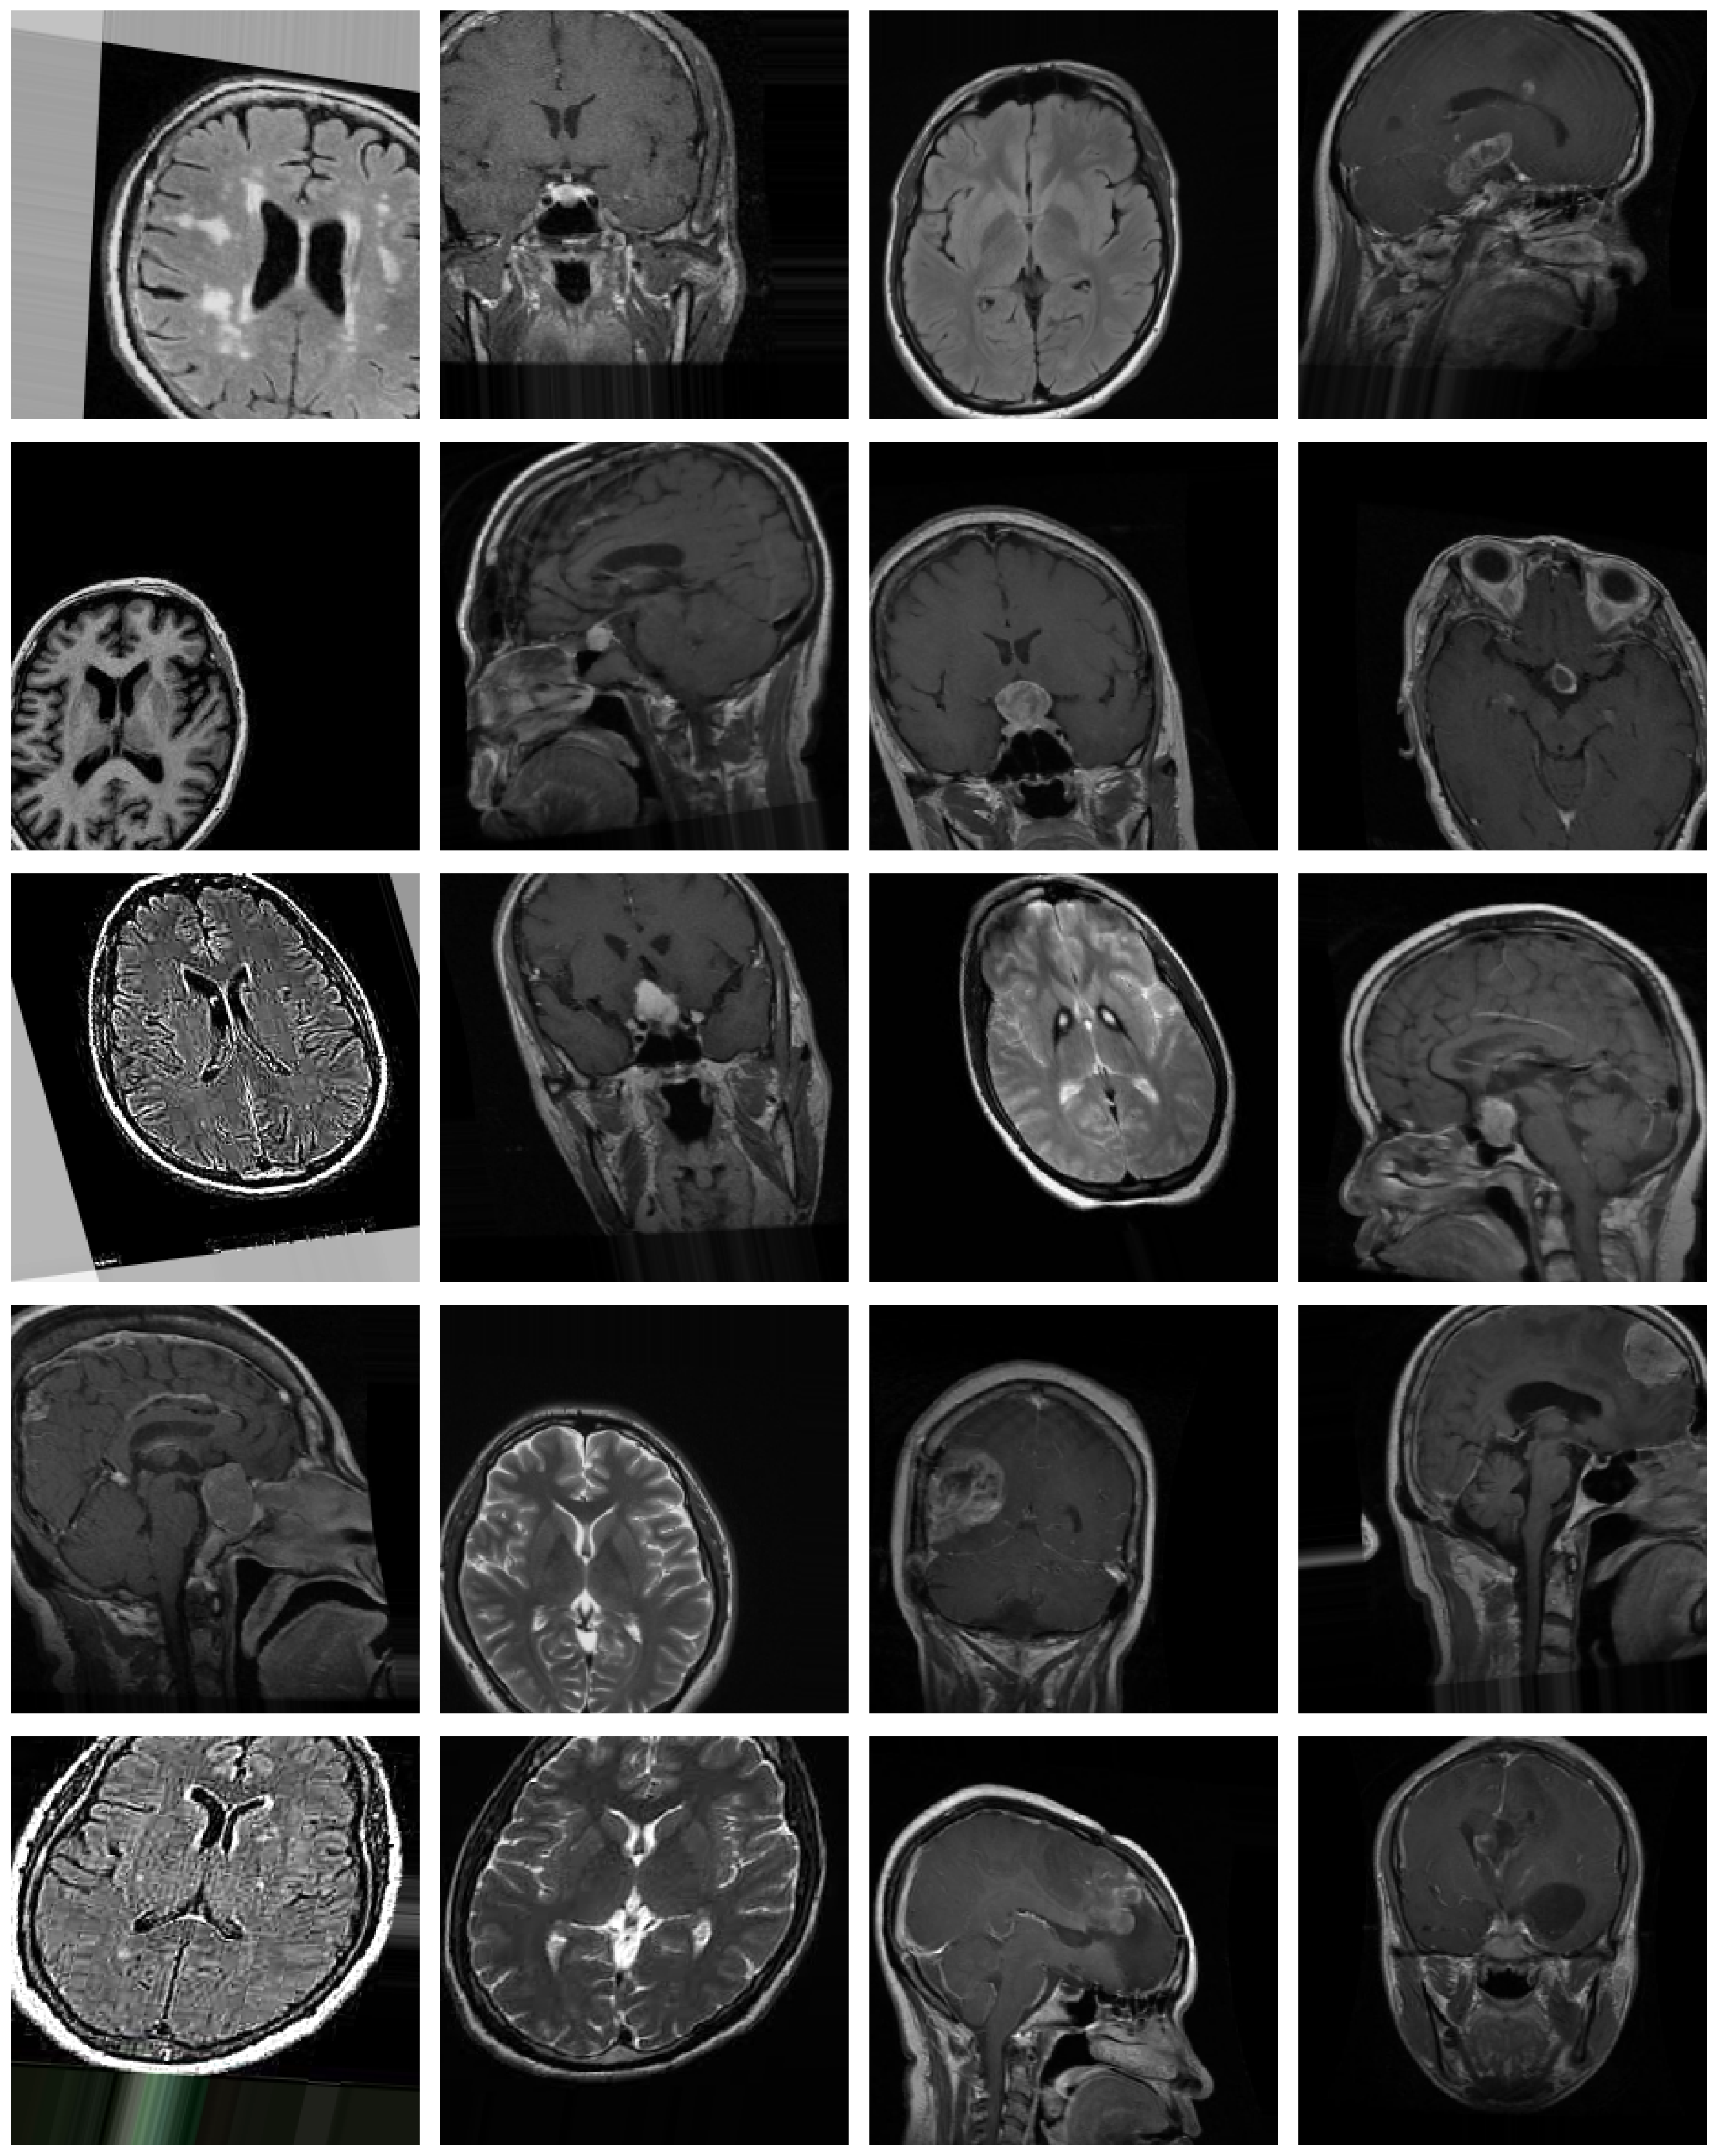

In [ ]:
show_images_ImageDataGenerator(train_datagen, num_samples=20, save=SAVE)

In [ ]:
# Image shape: height, width, RBG
image_shape = (224,224,3)

# Training epochs
epochs = 20

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (224, 224, 3)
Epochs: 20
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


***

<a name='a_cnn'>
    
# <span style='color:blue'>|</span> Evaluation Metrics
    


### <b> <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Precision <b>
Precision measures the ability of the model to correctly identify positive instances for each class among all instances predicted as positive.


$$
\text{Precision}_c = \frac{{\text{TP}_c}}{{\text{TP}_c + \text{FP}_c}}
$$

### <b> <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Recall (Sensitivity or True Positive Rate) <b>
Recall calculates the ability of the model to correctly identify positive instances for each class among all actual positive instances.


$$
\text{Recall}_c = \frac{{\text{TP}_c}}{{\text{TP}_c + \text{FN}_c}}
$$

### <b> <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  F1-Score <b>
The F1-score is the harmonic mean of precision and recall. It provides a balanced measure that combines both metrics for each class.


$$
\text{F1-Score}_c = 2 \times \frac{{\text{Precision}_c \times \text{Recall}_c}}{{\text{Precision}_c + \text{Recall}_c}}
$$

### <b><span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Accuracy <b>
Accuracy measures the overall correctness of the model's predictions across all classes.


$$
\text{Accuracy} = \frac{{\text{TP}_1 + \text{TP}_2 + ... + \text{TP}_N}}{{\text{TP}_1 + \text{TP}_2 + ... + \text{TP}_N + \text{FP}_1 + \text{FP}_2 + ... + \text{FP}_N + \text{FN}_1 + \text{FN}_2 + ... + \text{FN}_N}}
$$

---

In [ ]:
# ––––––––––––––––––––––––––––––––––––––------------------------ #
# Output Images and Labels Visualization #
# –––––––––––––––––––––––––––––––––––––– ------------------------#
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    """
    Nice display of the prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)

    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")

        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)

    plt.tight_layout()
    plt.show()


# ––––––––––––––––––––––––––––––––––––––-------------------------#
#            Confusion matrix            #
# A confusion matrix is a table summarizing the performance of a classification
# model by showing the counts of true positives, true negatives, false positives, and false negatives.
# These elements help quantify the model's accuracy, precision, recall, and other performance metrics.
# ––––––––––––––––––––––––––––––––––––––-------------------------#
def CM(CNN_model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)

    return confusion_matrix_array


# ––––––––––––––––––––––––––––––––––––––-------------------------#
#             Metric Analysis            #
# Metric analysis provides a quantitative assessment of a model's performance
# using various metrics such as accuracy, precision, recall, and F1-score,
# offering insights into its effectiveness in making predictions.
# ––––––––––––––––––––––––––––––––––––––--------------------------#
def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pywt
import pywt.data

# Defining the wavelet function
def Apply_wavelet(img_path,label):
  original = Image.open(img_path)
  titles = [f'{label} Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
  coeffs2 = pywt.dwt2(original, 'bior1.3')
  LL, (LH, HL, HH) = coeffs2
  fig = plt.figure(figsize=(12, 3))
  for i, a in enumerate([LL, LH, HL, HH]):
            ax = fig.add_subplot(1, 4, i + 1)
            ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
            ax.set_title(titles[i], fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
  fig.tight_layout()
  plt.show()

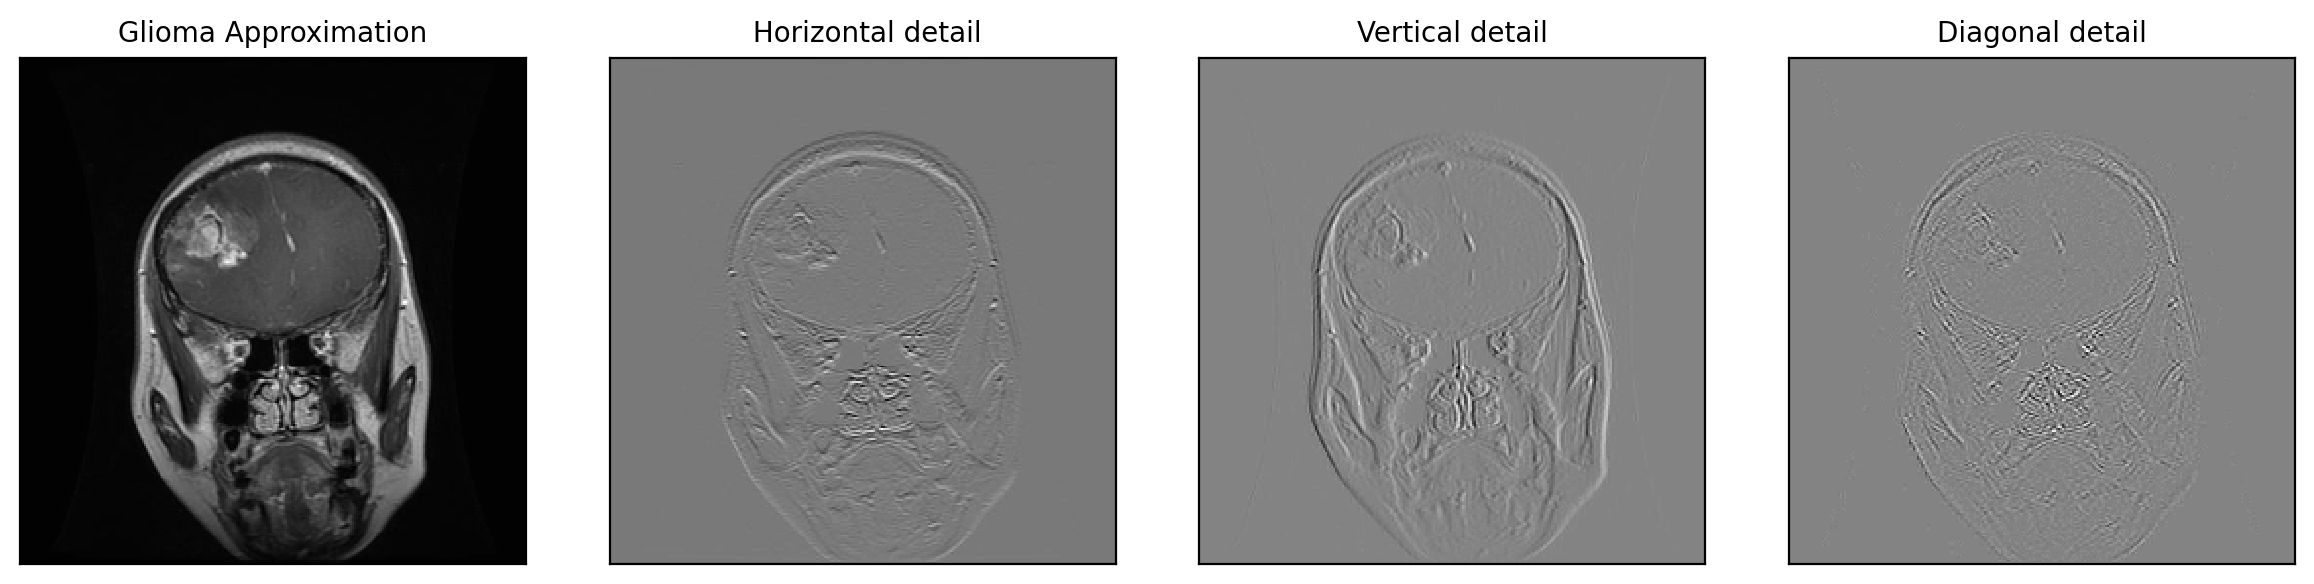

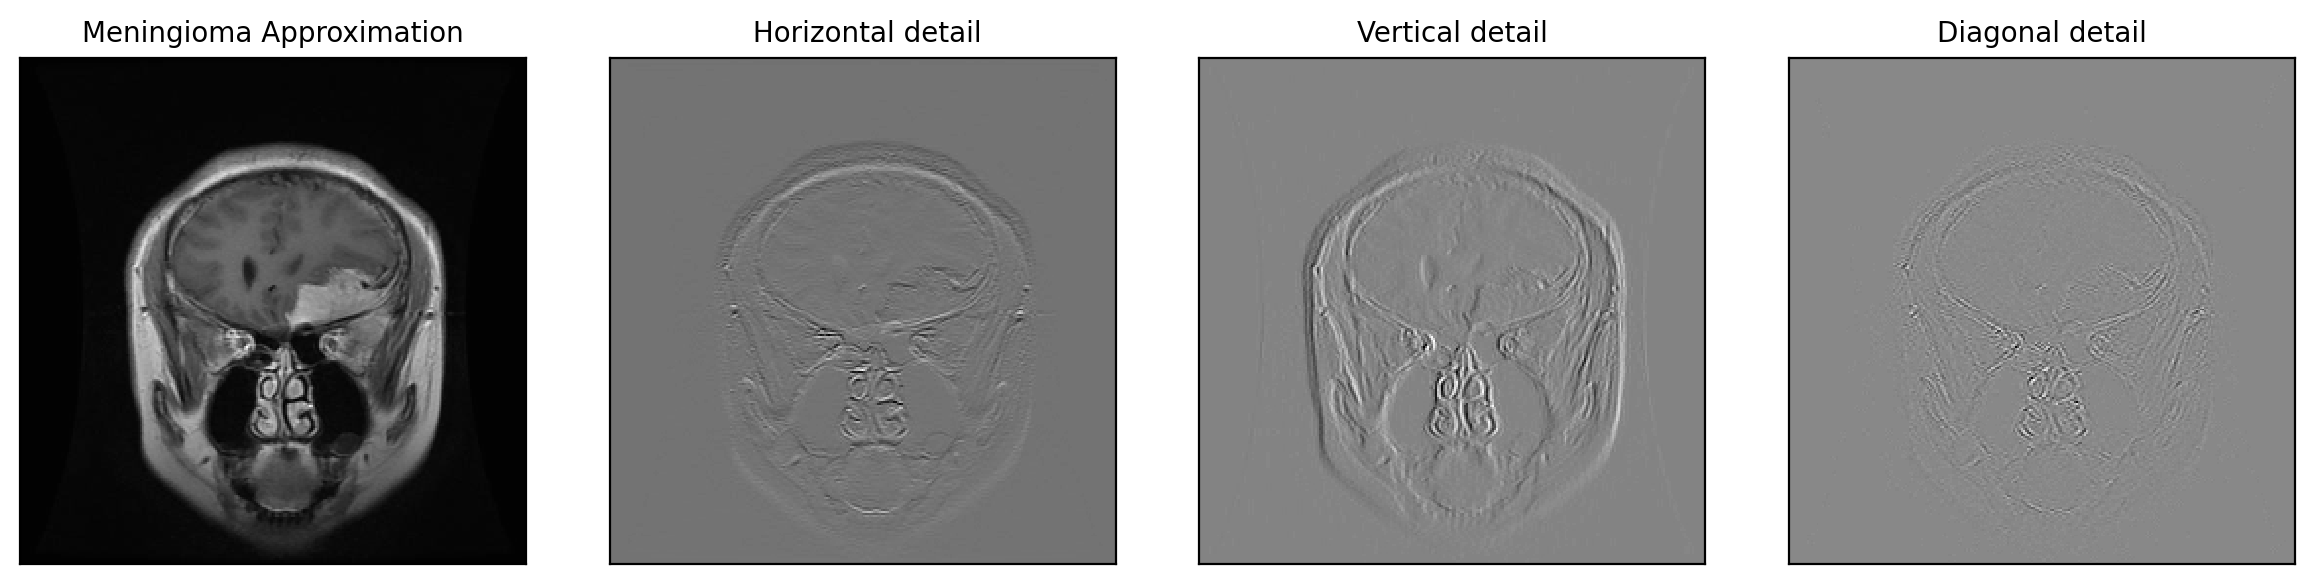

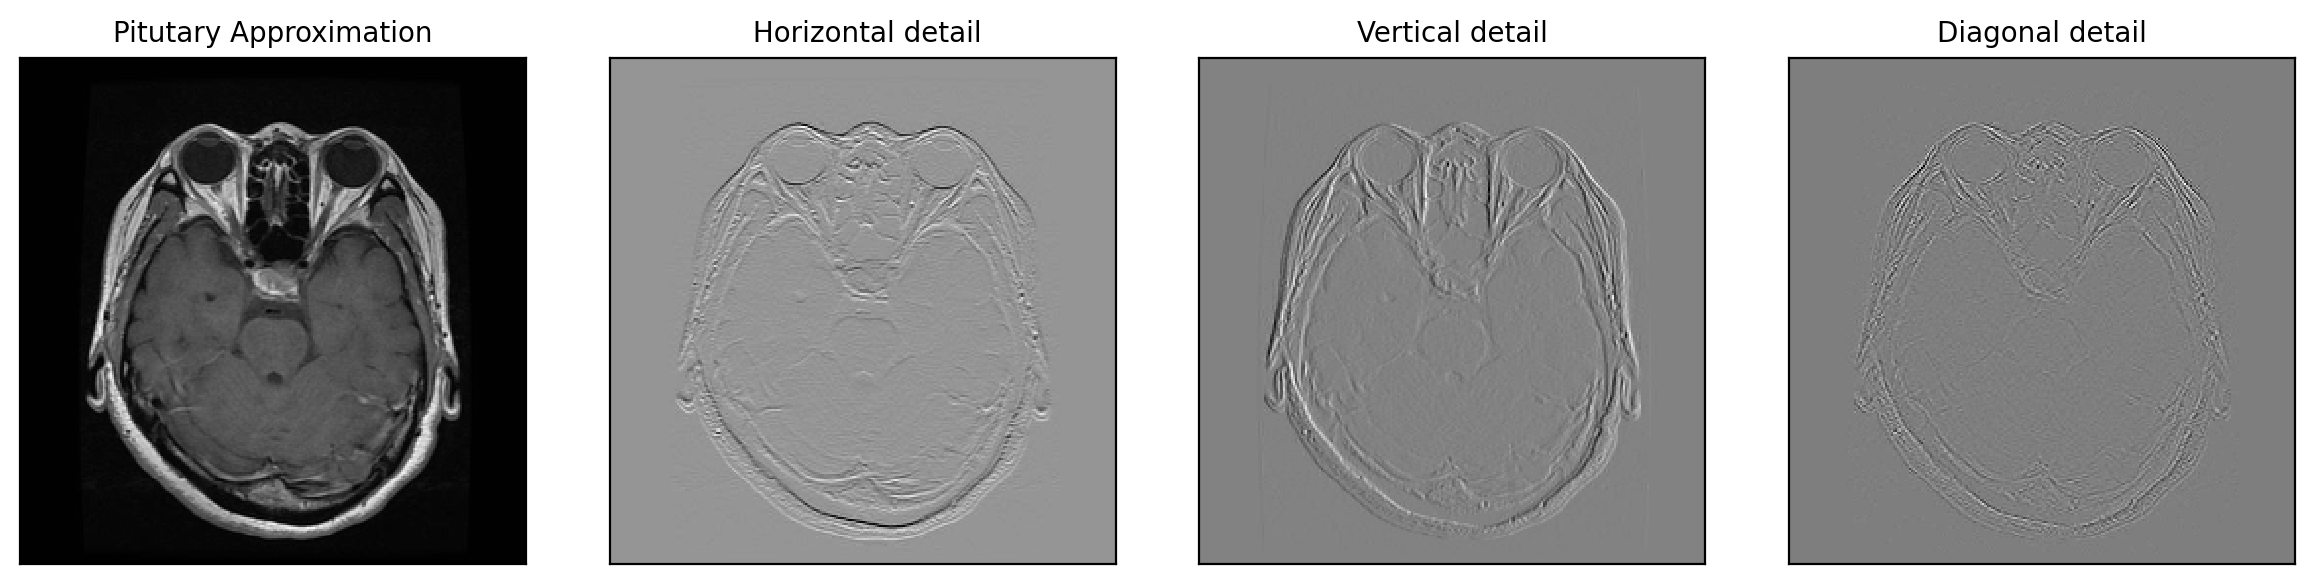

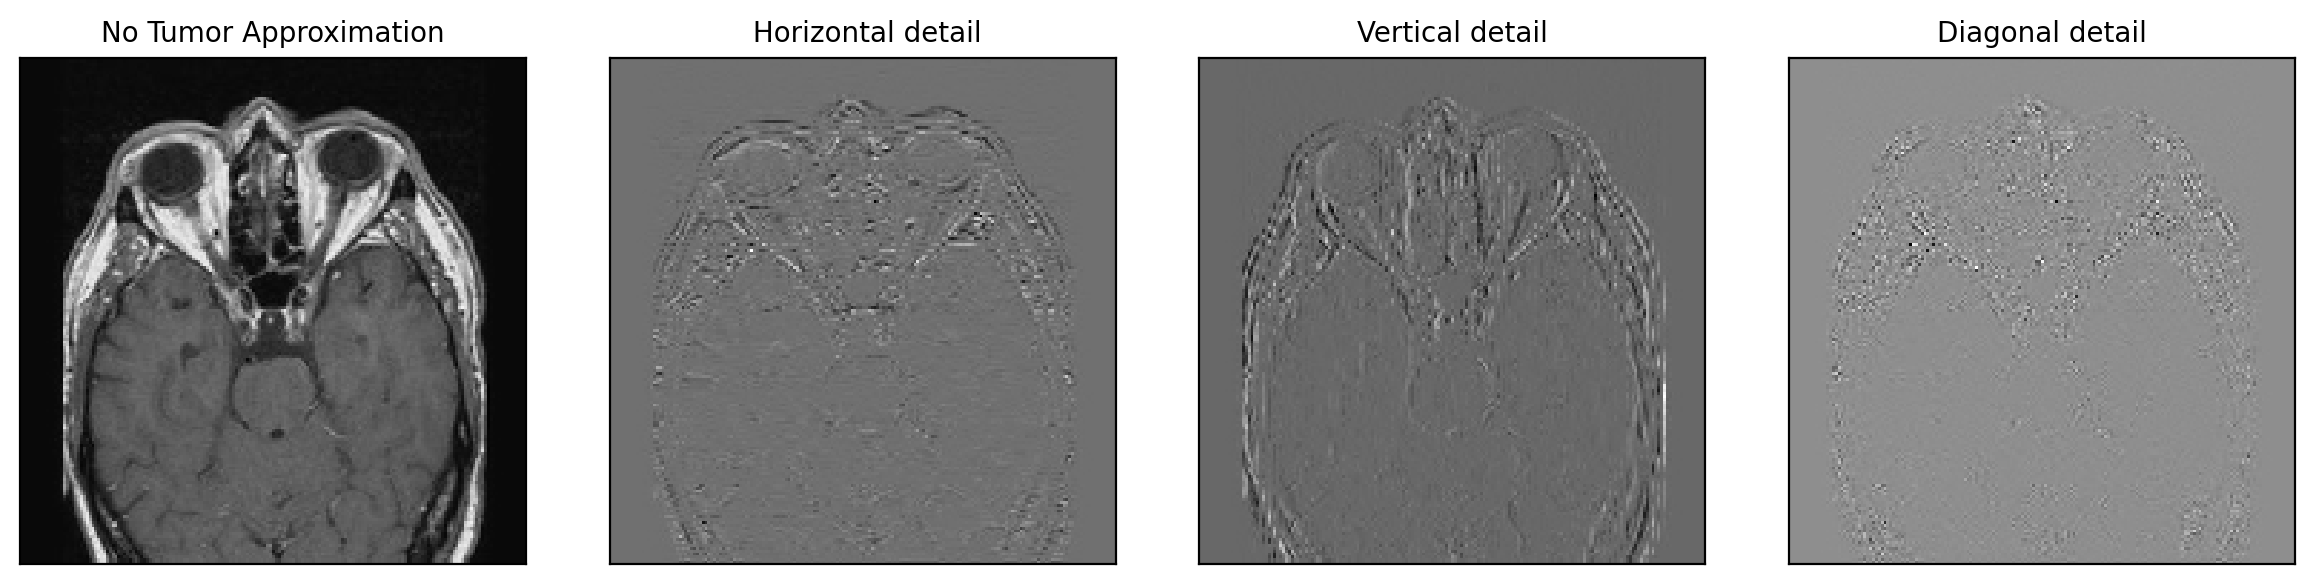

In [ ]:
Apply_wavelet('/content/Brain_tumor_dataset/Training/glioma/Tr-glTr_0000.jpg','Glioma')
Apply_wavelet('/content/Brain_tumor_dataset/Training/meningioma/Tr-meTr_0000.jpg','Meningioma')
Apply_wavelet('/content/Brain_tumor_dataset/Training/pituitary/Tr-piTr_0000.jpg','Pitutary')
Apply_wavelet('/content/Brain_tumor_dataset/Training/notumor/Tr-noTr_0000.jpg','No Tumor')

In [ ]:
# ANN MOdel
from tensorflow.keras import models, layers


model_ANN = models.Sequential()

# Add Flatten layer to convert 2D input to 1D
model_ANN.add(layers.Flatten(input_shape = image_shape))

model_ANN.add(layers.Dense(512, activation='relu'))
model_ANN.add(layers.Dropout(0.4))
model_ANN.add(layers.Dense(32, activation='relu'))
model_ANN.add(layers.Dropout(0.4))
model_ANN.add(layers.Dense(N_TYPES, activation='softmax'))

model_ANN.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_ANN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                16416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 77087396 (294.07 MB)
Trainable params: 770

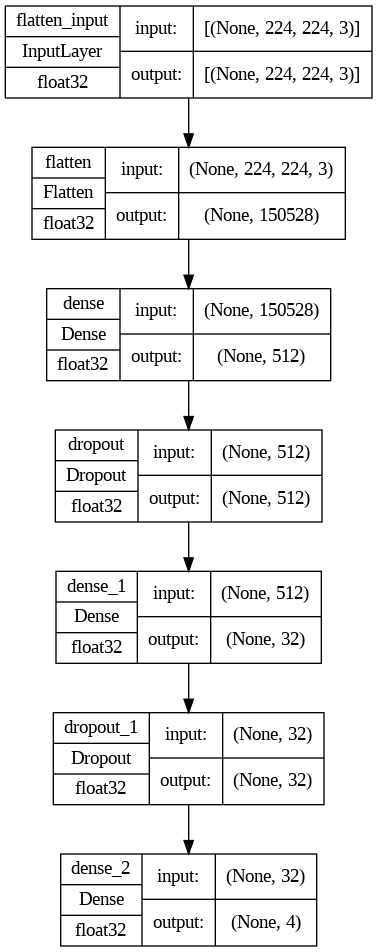

In [ ]:
model_ANN_visual = models.Model(inputs=model_ANN.input,
                                outputs=model_ANN.output)

# Save model architecture to a file
plot_model(model_ANN_visual , show_dtype=True,
           to_file='model_ANN_architecture.png',
           show_shapes=True)

# Display model architecture in the notebook

from IPython.display import Image
Image(retina=True,
      filename='model_ANN_architecture.png')

In [ ]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', patience = 5, verbose=True)

# Training the model
history_ANN = model_ANN.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=test_generator,
                        validation_steps=validation_steps)

Epoch 1/20
178/178 [==============================] - 96s 502ms/step - loss: 2.4310 - accuracy: 0.2690 - val_loss: 1.3840 - val_accuracy: 0.3164
Epoch 2/20
178/178 [==============================] - 91s 511ms/step - loss: 1.4092 - accuracy: 0.2783 - val_loss: 1.3826 - val_accuracy: 0.3164
Epoch 3/20
178/178 [==============================] - 91s 511ms/step - loss: 1.4153 - accuracy: 0.2789 - val_loss: 1.3819 - val_accuracy: 0.3164
Epoch 4/20
178/178 [==============================] - 91s 512ms/step - loss: 1.3860 - accuracy: 0.2796 - val_loss: 1.3813 - val_accuracy: 0.3164
Epoch 5/20
178/178 [==============================] - 92s 516ms/step - loss: 1.3853 - accuracy: 0.2794 - val_loss: 1.3811 - val_accuracy: 0.3164
Epoch 6/20
178/178 [==============================] - 91s 513ms/step - loss: 1.3866 - accuracy: 0.2789 - val_loss: 1.3808 - val_accuracy: 0.3164
Epoch 7/20
178/178 [==============================] - 91s 514ms/step - loss: 1.3908 - accuracy: 0.2794 - val_loss: 1.3806 - val_ac

In [ ]:

# Define the CNN model architecture
model_CNN = models.Sequential()

# Convolutional layer 1
model_CNN .add(Conv2D(32, (4, 4), activation="relu",
                      input_shape=image_shape))
model_CNN .add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_CNN .add(Conv2D(64, (4, 4), activation="relu"))
model_CNN .add(MaxPooling2D(pool_size=(3, 3)))


# Convolutional layer 3
model_CNN .add(Conv2D(128, (4, 4), activation="relu"))
model_CNN .add(Flatten())

# Full connect layers
model_CNN .add(Dense(512, activation="relu"))
model_CNN .add(Dropout(0.5, seed=SEED))
model_CNN .add(Dense(N_TYPES, activation="softmax"))

model_CNN .summary()


optimizer = legacy.Adam(learning_rate=0.001)

model_CNN .compile(optimizer=optimizer,
                   loss='categorical_crossentropy',
                   metrics= ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 221, 221, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       131200    
                                                                 
 flatten_1 (Flatten)         (None, 51200)            

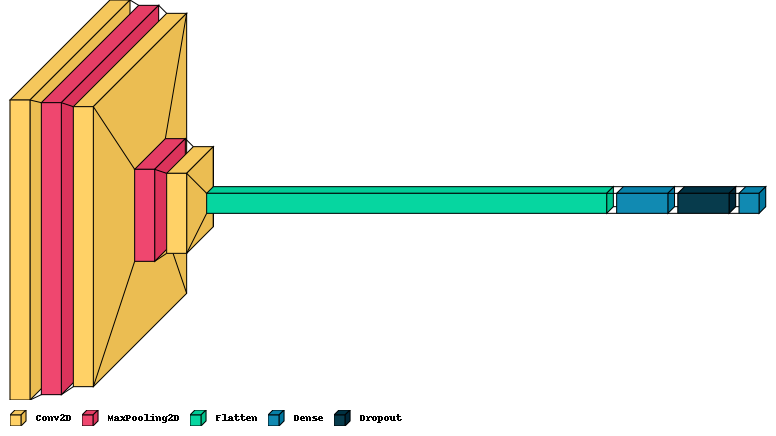

In [ ]:
from visualkeras import layered_view

# Visualize the model
layered_view(model_CNN, legend=True, max_xy=300)

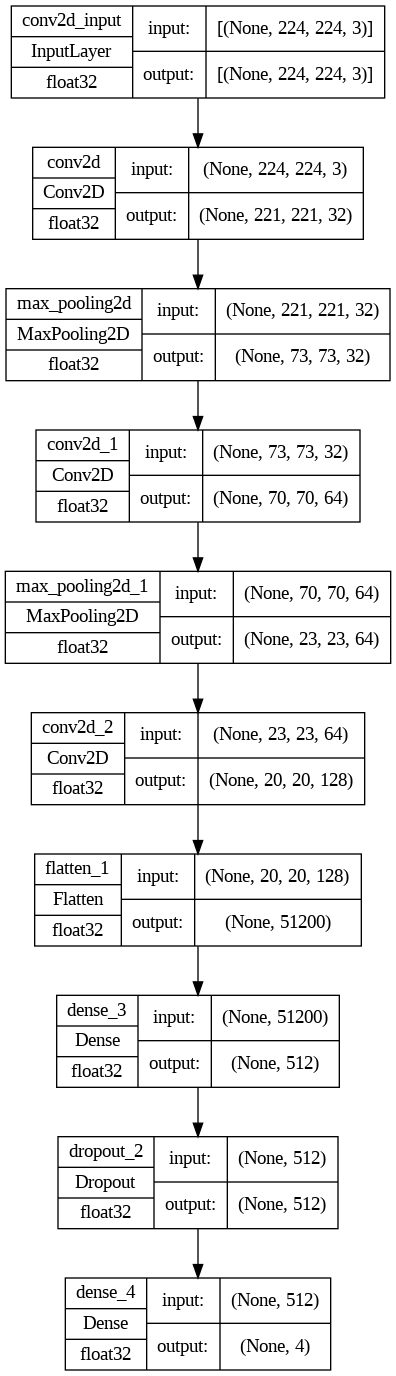

In [ ]:
model_CNN_visual = models.Model(inputs=model_CNN.input, outputs=model_CNN.output)

# Save model architecture to a file
plot_model(model_CNN_visual, show_dtype=True, to_file='model_CNN_architecture.png', show_shapes=True)

# Display model architecture in the notebook

from IPython.display import Image
Image(retina=True, filename='model_CNN_architecture.png')

In [ ]:
# Training the model
history_CNN = model_CNN.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=test_generator,
                        validation_steps=validation_steps,
                        callbacks = [model_es])

Epoch 1/20
178/178 [==============================] - 102s 539ms/step - loss: 1.0212 - accuracy: 0.5495 - val_loss: 0.8640 - val_accuracy: 0.6633
Epoch 2/20
178/178 [==============================] - 91s 509ms/step - loss: 0.8035 - accuracy: 0.6655 - val_loss: 0.7040 - val_accuracy: 0.7352
Epoch 3/20
178/178 [==============================] - 91s 513ms/step - loss: 0.6580 - accuracy: 0.7262 - val_loss: 0.6434 - val_accuracy: 0.7406
Epoch 4/20
178/178 [==============================] - 89s 500ms/step - loss: 0.5783 - accuracy: 0.7692 - val_loss: 0.5693 - val_accuracy: 0.7766
Epoch 5/20
178/178 [==============================] - 88s 496ms/step - loss: 0.5608 - accuracy: 0.7820 - val_loss: 0.5513 - val_accuracy: 0.7852
Epoch 6/20
178/178 [==============================] - 92s 517ms/step - loss: 0.5043 - accuracy: 0.7938 - val_loss: 0.5062 - val_accuracy: 0.7953
Epoch 7/20
178/178 [==============================] - 89s 498ms/step - loss: 0.4779 - accuracy: 0.8113 - val_loss: 0.5690 - val_a

In [ ]:
# Evaluating the model
loss_ANN, accuracy_ANN = model_ANN.evaluate(test_generator,
                                            steps=test_generator.samples//batch_size)
print(f"Test Loss for ANN model  : {loss_ANN:0.5f}")
print(f"Test Accuracy for ANN model  : {accuracy_ANN:0.5f}")

40/40 [==============================] - 4s 90ms/step - loss: 1.3806 - accuracy: 0.3164
Test Loss for ANN model  : 1.38057
Test Accuracy for ANN model  : 0.31641


In [ ]:
# Evaluating the model
loss_CNN, accuracy_CNN = model_CNN.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss for CNN model  : {loss_CNN:0.5f}")
print(f"Test Accuracy for CNN model  : {accuracy_CNN:0.5f}")

40/40 [==============================] - 5s 107ms/step - loss: 0.3579 - accuracy: 0.8750
Test Loss for CNN model  : 0.35788
Test Accuracy for CNN model  : 0.87500


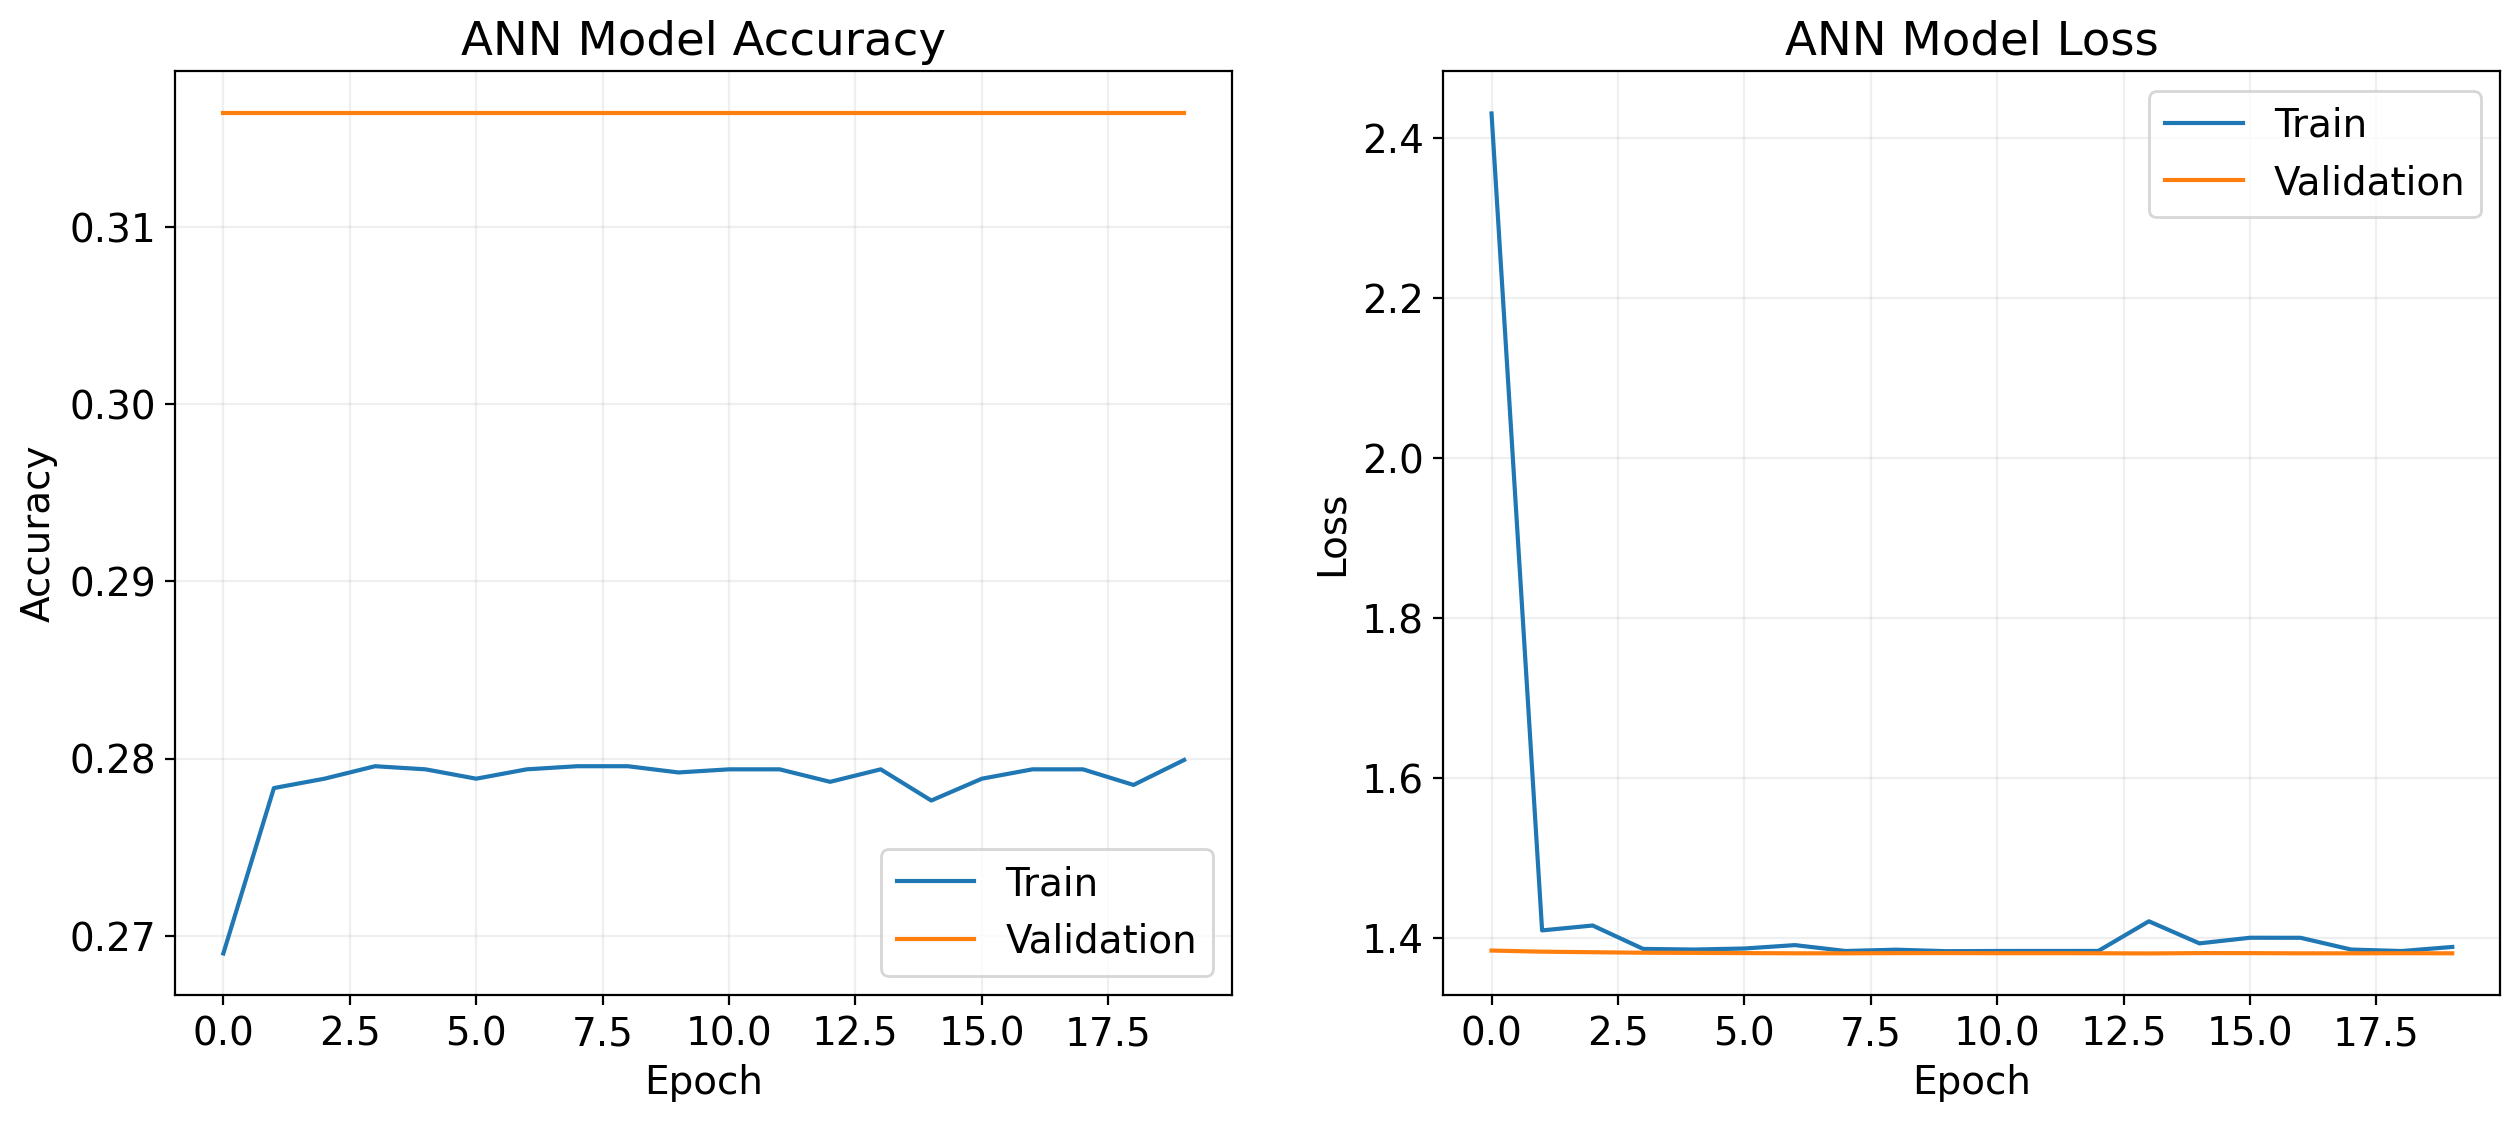

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history_ANN.history['accuracy'])
ax[0].plot(history_ANN.history['val_accuracy'])
ax[0].set_title('ANN Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history_ANN.history['loss'])
ax[1].plot(history_ANN.history['val_loss'])
ax[1].set_title('ANN Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

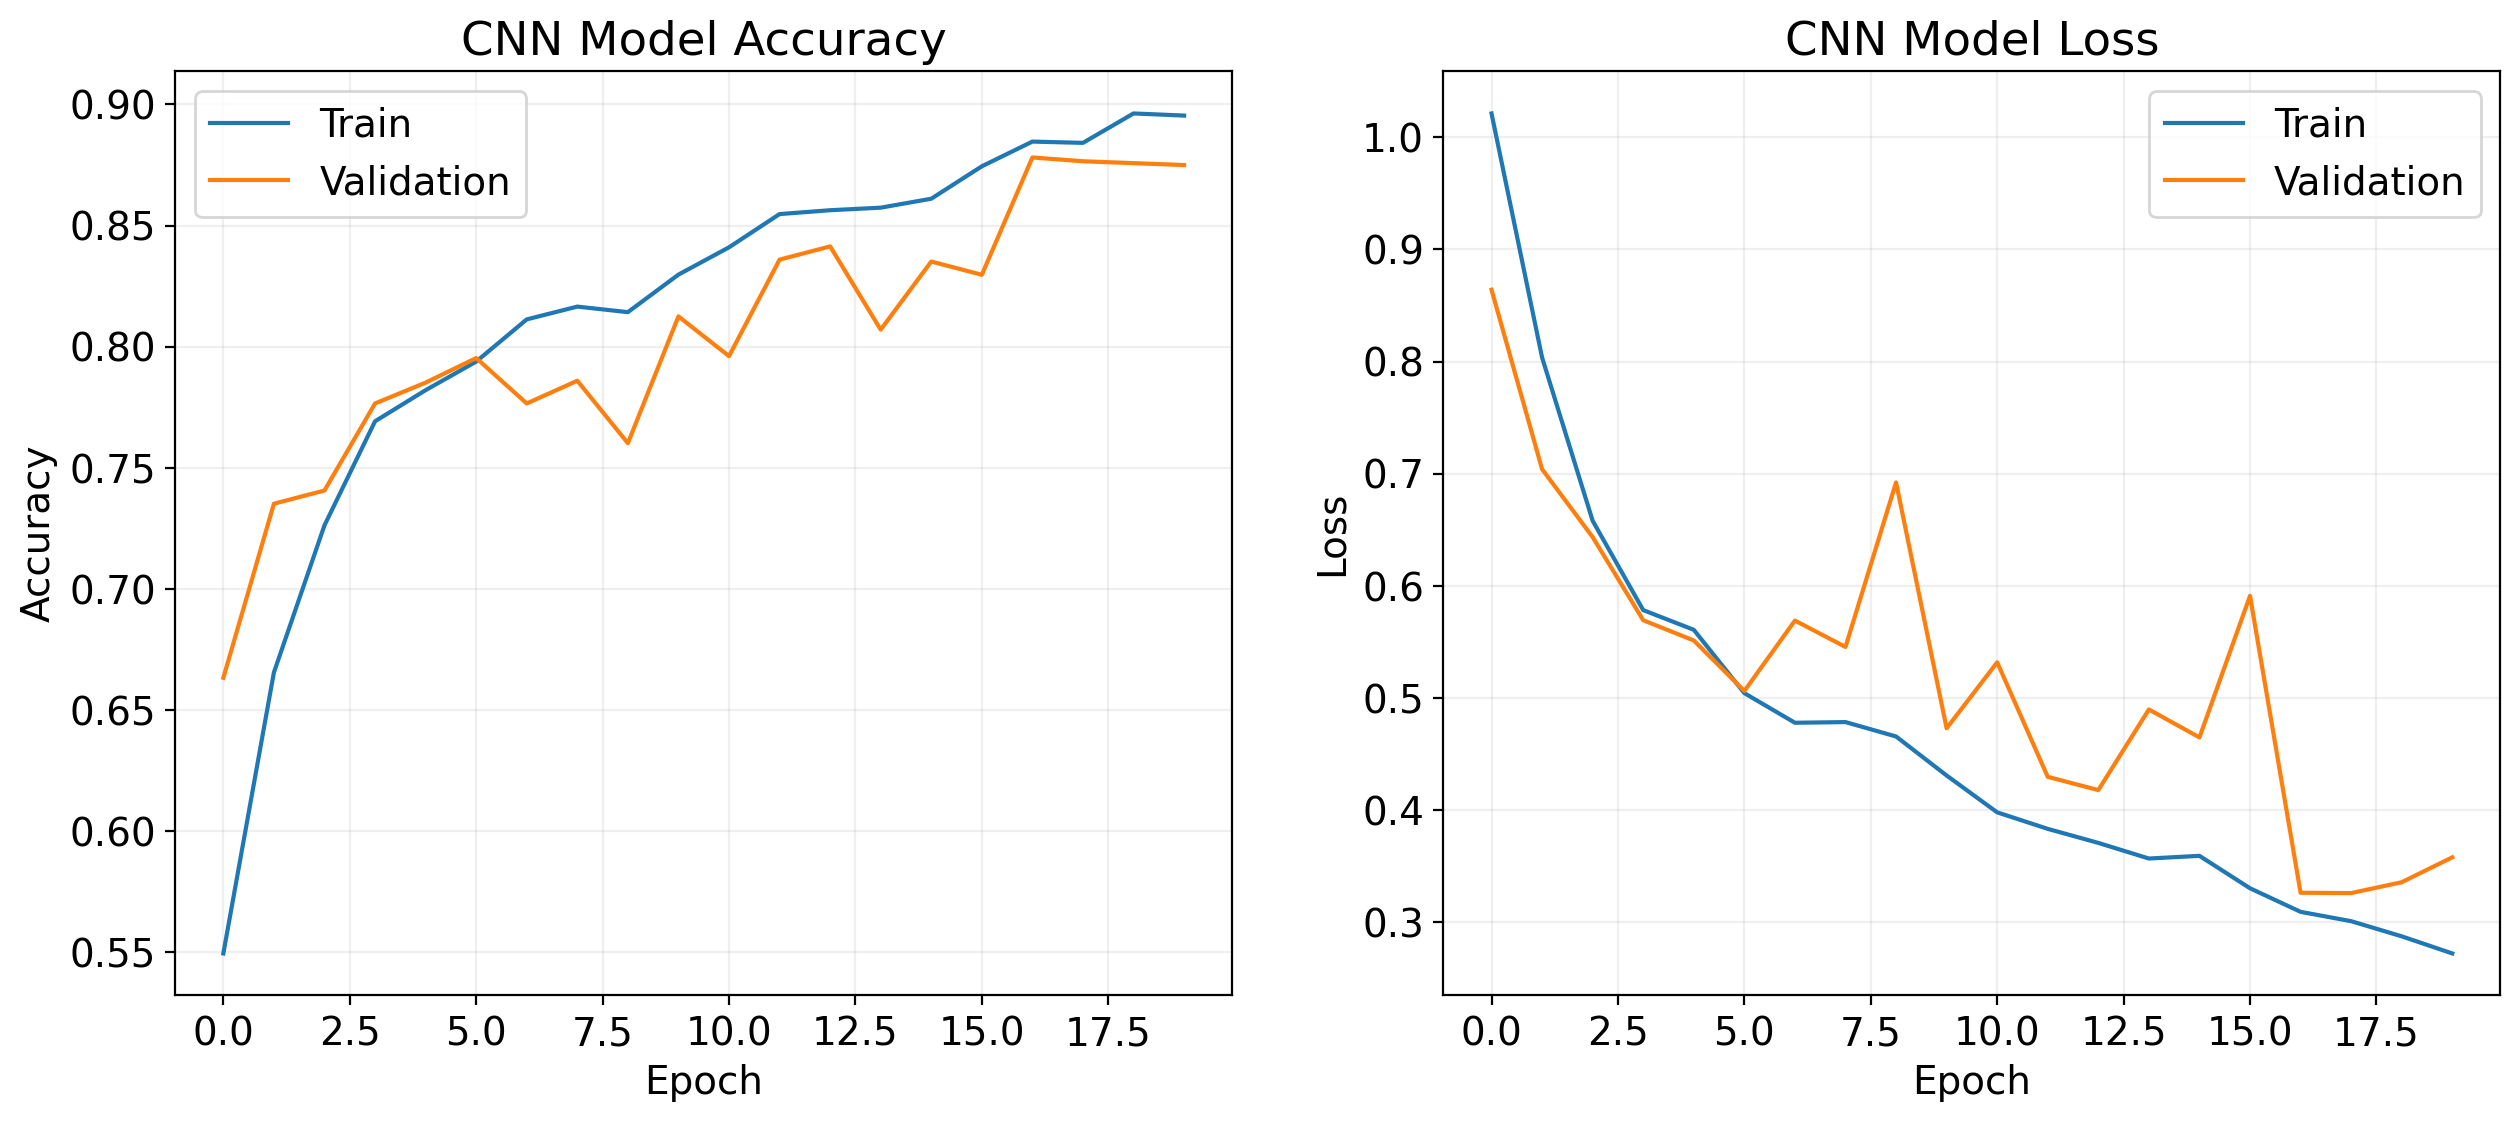

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history_CNN.history['accuracy'])
ax[0].plot(history_CNN.history['val_accuracy'])
ax[0].set_title('CNN Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history_CNN.history['loss'])
ax[1].plot(history_CNN.history['val_loss'])
ax[1].set_title('CNN Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

41/41 [==============================] - 3s 79ms/step


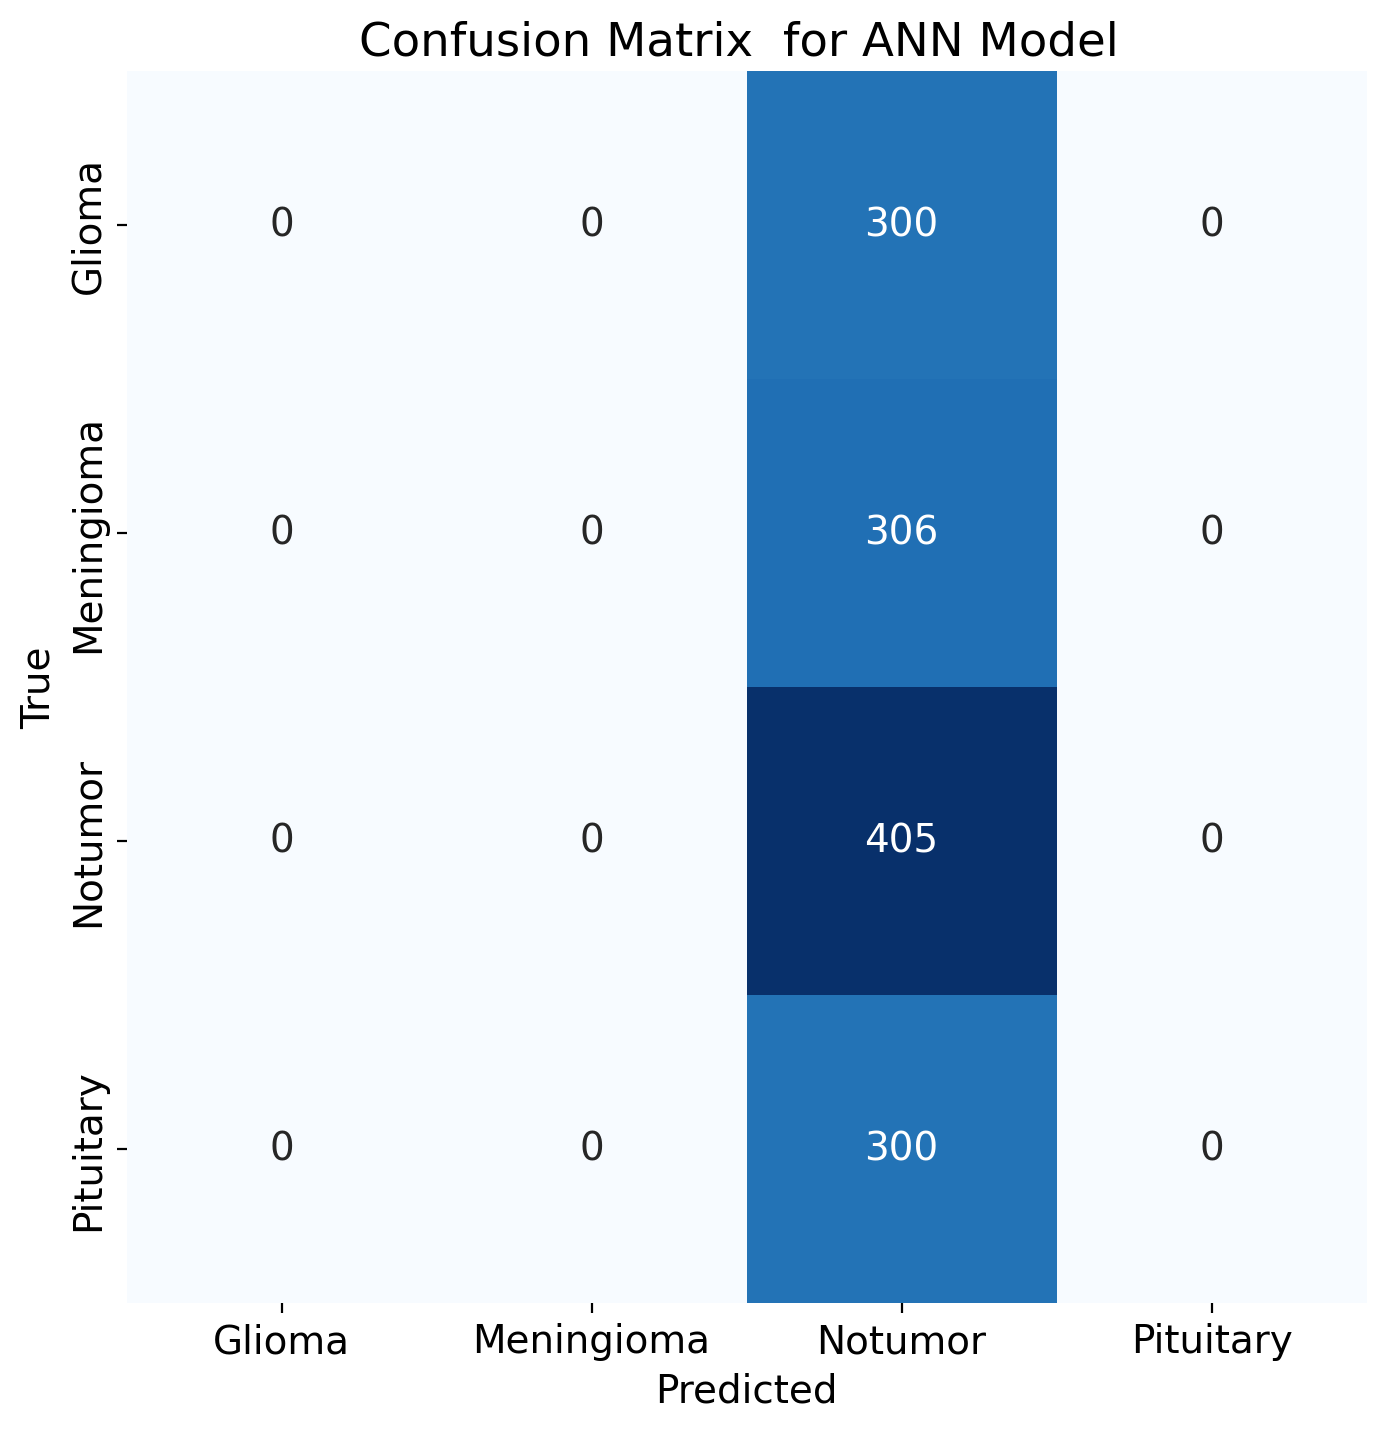

In [ ]:
# Plotting confusion matrix
confusion_matrix_ANN = CM(CNN_model=model_ANN, test_generator=test_generator, categories=CLASS_TYPES)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix_ANN, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix  for ANN Model ")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

41/41 [==============================] - 3s 69ms/step


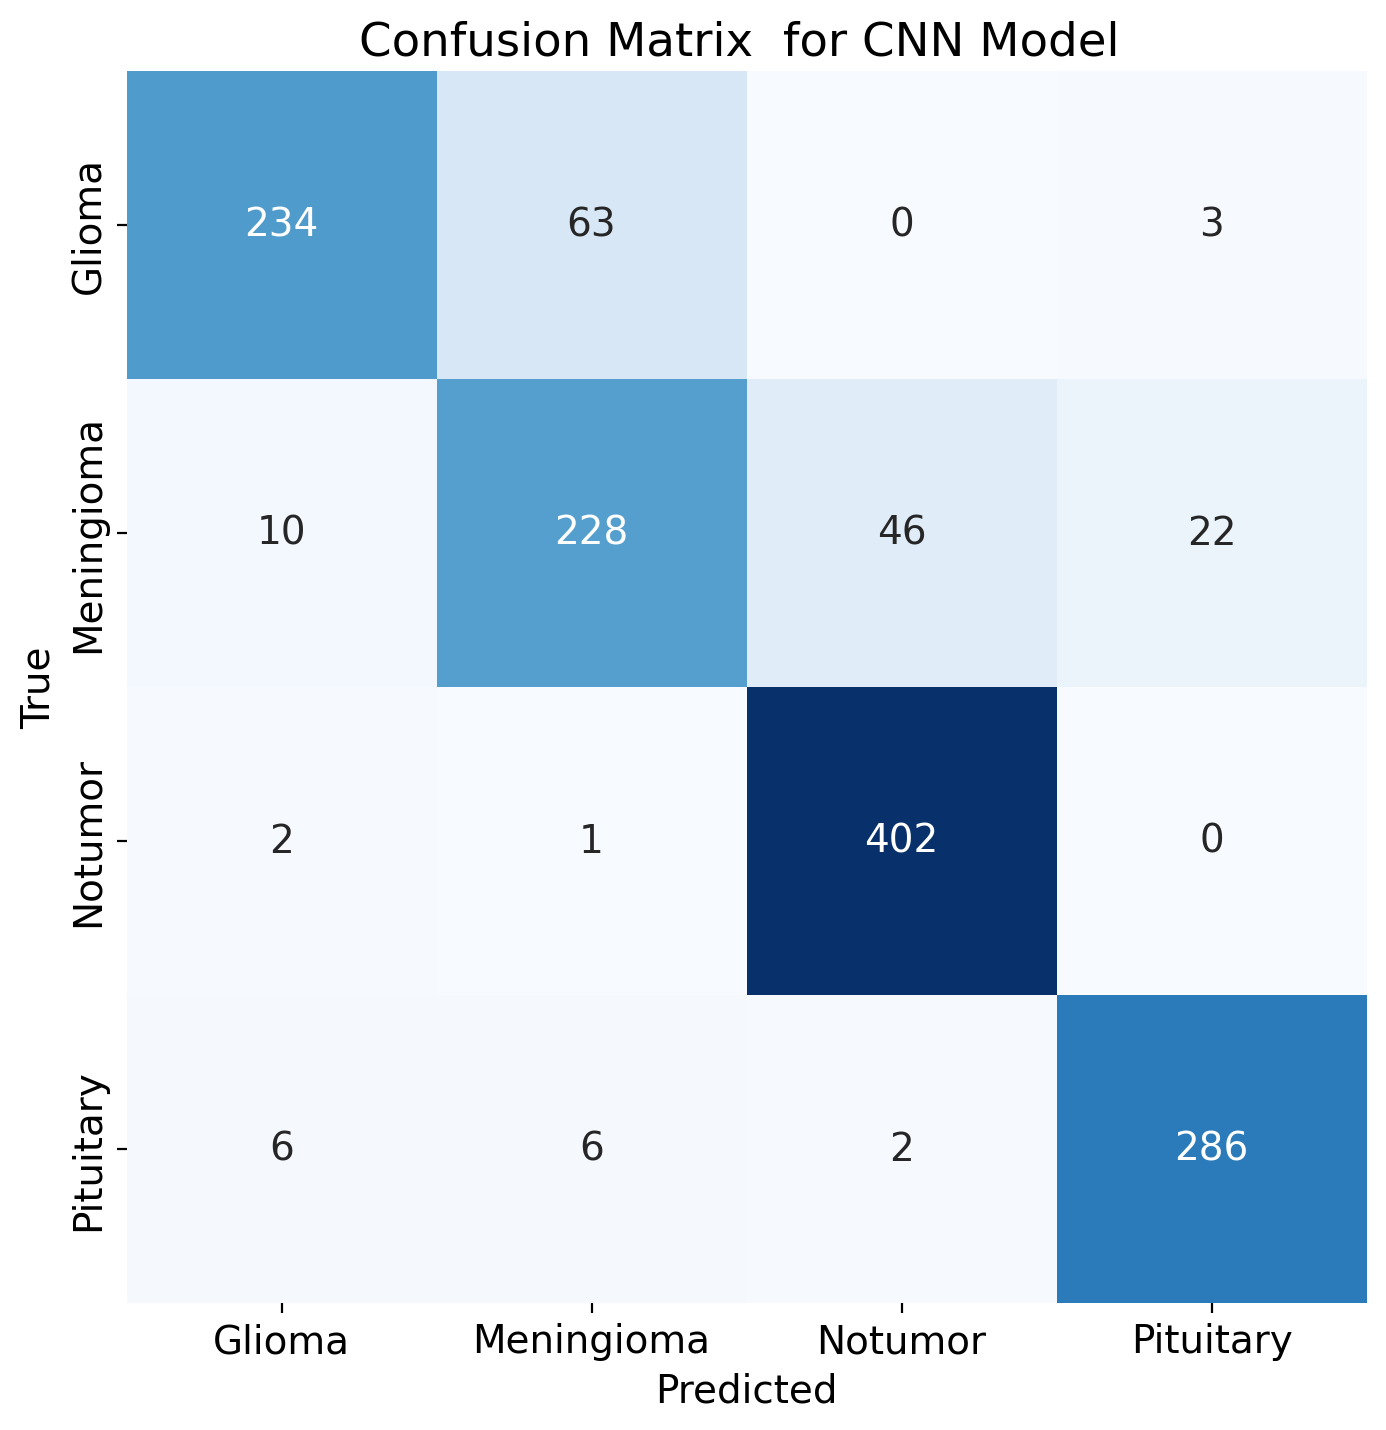

In [ ]:
# Plotting confusion matrix
confusion_matrix_CNN = CM(CNN_model=model_CNN, test_generator=test_generator, categories=CLASS_TYPES)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix_CNN, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix  for CNN Model ")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [ ]:
# Showing metrics
calculate_metrics(confusion_matrix_ANN, categories=CLASS_TYPES)

Class: Pituitary
Precision: nan
Recall: 0.000
F1-Score: nan

Class: Notumor
Precision: nan
Recall: 0.000
F1-Score: nan

Class: Meningioma
Precision: 0.309
Recall: 1.000
F1-Score: 0.472

Class: Glioma
Precision: nan
Recall: 0.000
F1-Score: nan


Accuracy: 0.309


<ipython-input-18-c721b8217ede>:67: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)


In [ ]:
# Showing metrics
calculate_metrics(confusion_matrix_CNN,
                  categories=CLASS_TYPES)

Class: Pituitary
Precision: 0.929
Recall: 0.780
F1-Score: 0.848

Class: Notumor
Precision: 0.765
Recall: 0.745
F1-Score: 0.755

Class: Meningioma
Precision: 0.893
Recall: 0.993
F1-Score: 0.940

Class: Glioma
Precision: 0.920
Recall: 0.953
F1-Score: 0.936


Accuracy: 0.877


<hr>
## Extrension as suggested: Use a pretrained network & report the performance.

Here I will use pre-trained model from the Keras Applications module, which is  MobileNetV2 model. It is a lightweight and efficient model that performs well for various image classification tasks.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths to your train and test data directories
USER_PATH = r"/content/Brain_Tumor_Dataset"
train_data_dir =  USER_PATH + r'/Training/'
test_data_dir = USER_PATH + r'/Testing/'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create ImageDataGenerator for testing data (only rescaling, no data augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create train and test data generators
num_classes = 4  # Update the number of classes

# Create train and test data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load MobileNetV2 with pre-trained weights from ImageNet [This is the pretrained network]
base_model = MobileNetV2(input_shape=(224,224,3),weights='imagenet', include_top=False)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a custom head to the model for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(32,activation = 'relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model_MV2 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_MV2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model_MV2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
# Train the model using the train_generator
history_model_MV2 = model_MV2.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=100,
    epochs=10  # Specify the number of epochs
)


# Evaluate the model on the test set
eval_result = model_MV2.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)

print("Test Accuracy:", eval_result[1])


Epoch 1/10
100/100 [==============================] - 64s 610ms/step - loss: 0.5078 - accuracy: 0.8065 - val_loss: 0.4068 - val_accuracy: 0.8642
Epoch 2/10
100/100 [==============================] - 51s 514ms/step - loss: 0.3263 - accuracy: 0.8822 - val_loss: 0.3757 - val_accuracy: 0.8558
Epoch 3/10
100/100 [==============================] - 53s 531ms/step - loss: 0.2816 - accuracy: 0.8995 - val_loss: 0.3229 - val_accuracy: 0.8696
Epoch 4/10
100/100 [==============================] - 51s 516ms/step - loss: 0.2337 - accuracy: 0.9141 - val_loss: 0.4392 - val_accuracy: 0.8436
Epoch 5/10
100/100 [==============================] - 51s 514ms/step - loss: 0.2165 - accuracy: 0.9216 - val_loss: 0.2882 - val_accuracy: 0.8947
Epoch 6/10
100/100 [==============================] - 51s 507ms/step - loss: 0.2047 - accuracy: 0.9274 - val_loss: 0.3999 - val_accuracy: 0.8490
Epoch 7/10
100/100 [==============================] - 50s 494ms/step - loss: 0.2087 - accuracy: 0.9216 - val_loss: 0.2730 - val_ac

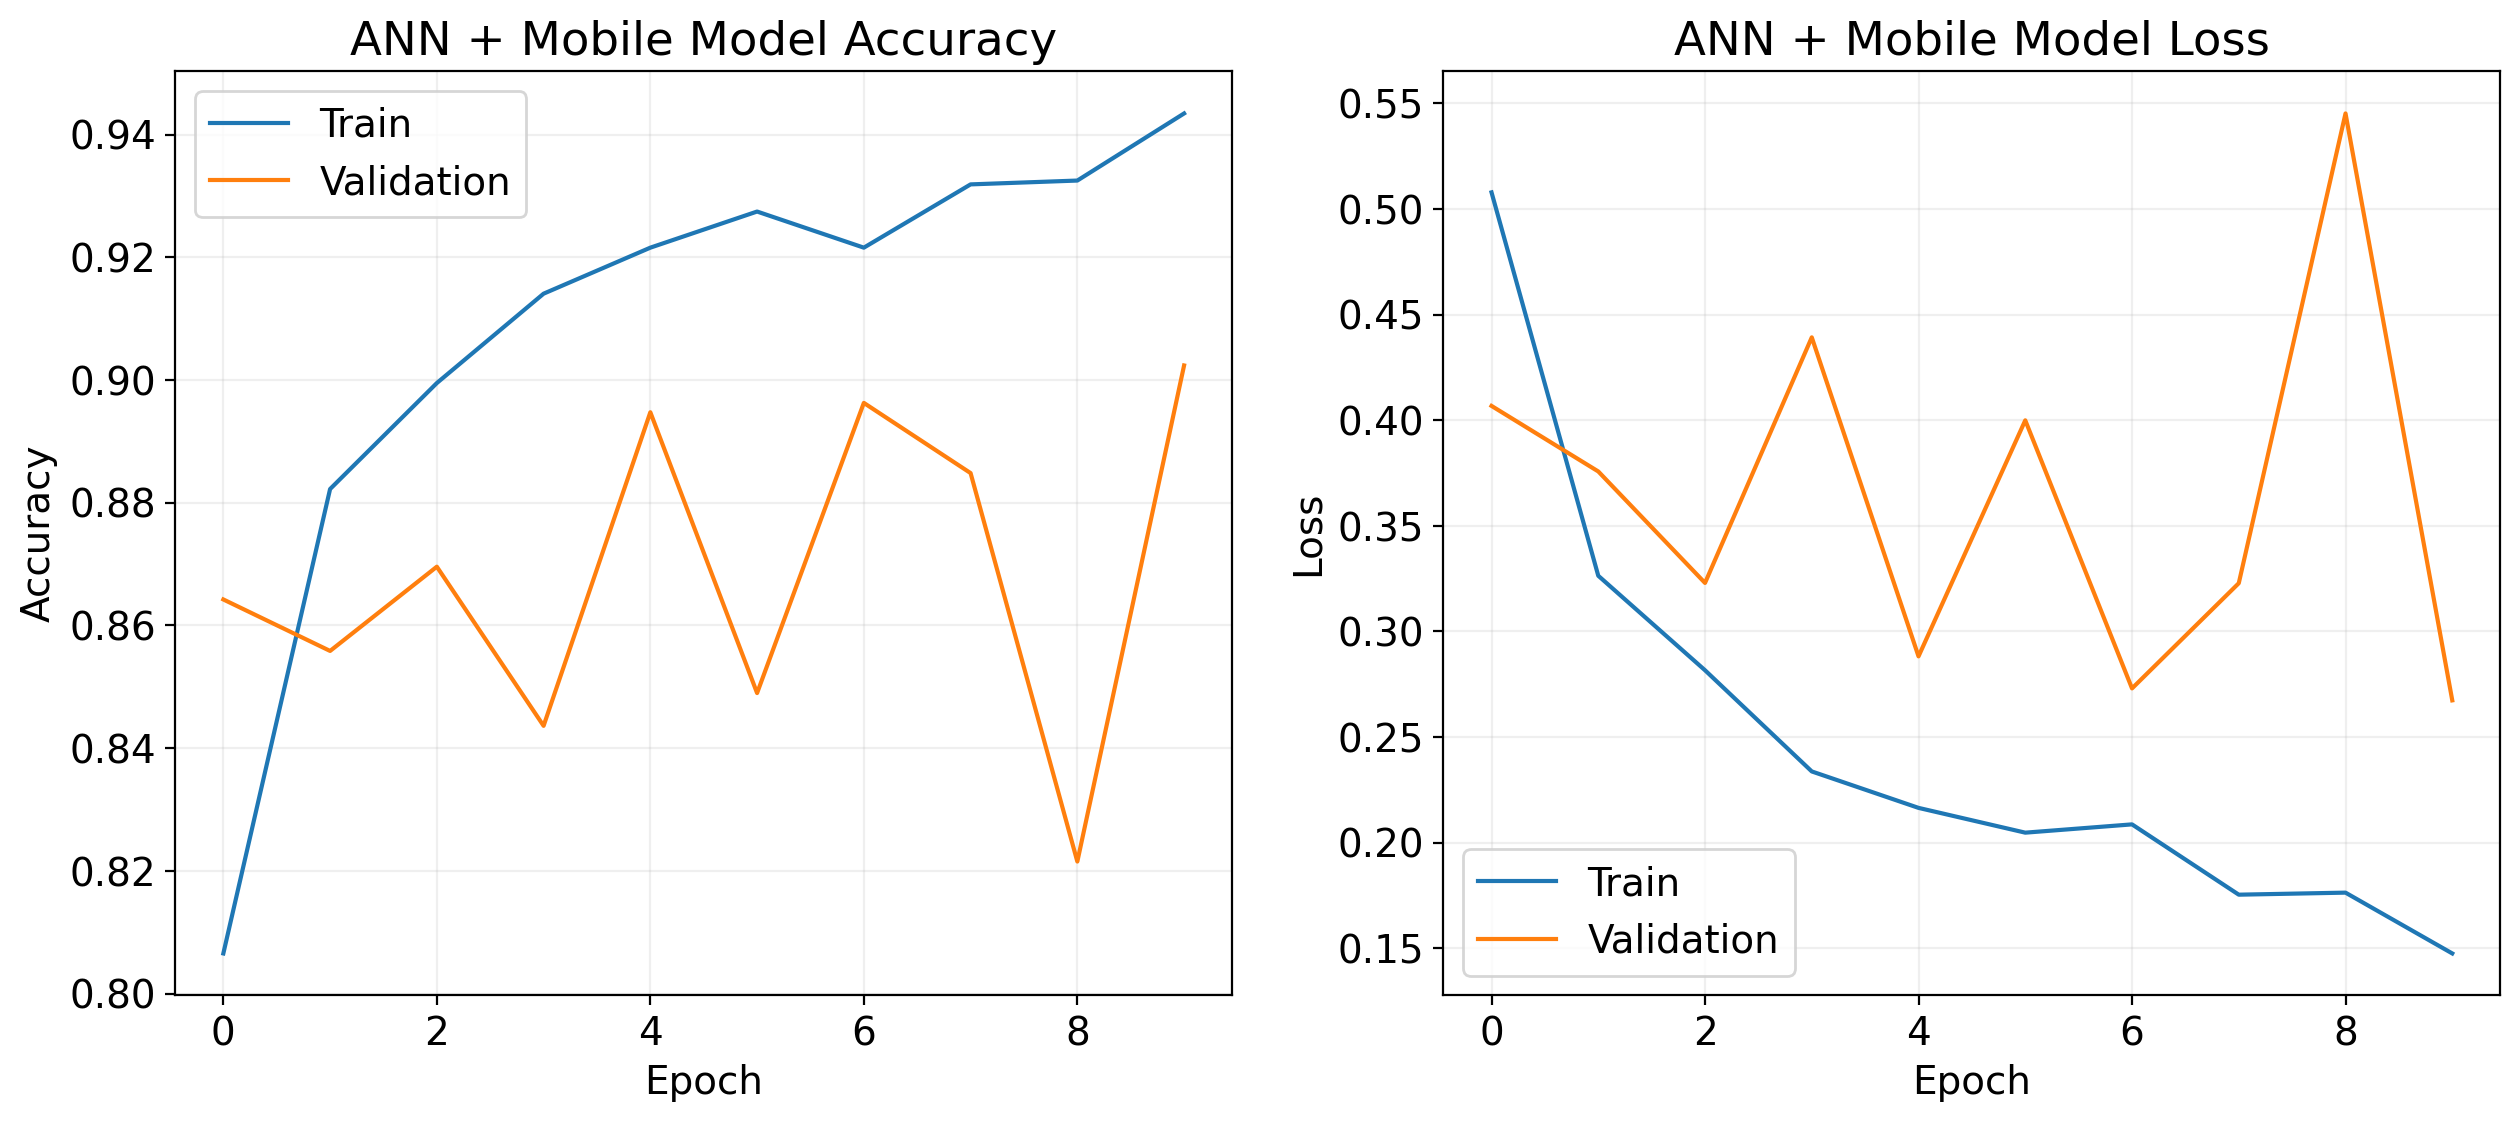

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history_model_MV2.history['accuracy'])
ax[0].plot(history_model_MV2.history['val_accuracy'])
ax[0].set_title('ANN + Mobile Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history_model_MV2.history['loss'])
ax[1].plot(history_model_MV2.history['val_loss'])
ax[1].set_title('ANN + Mobile Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()